In [ ]:
# librerias para manejo de datos

use_plotly = False
import scipy
import random
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import figure_factory as ff
from plotly.subplots import make_subplots
if use_plotly:
    import plotly.graph_objects as go
    import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from minisom import MiniSom
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

In [ ]:
mat_data = scipy.io.loadmat('/content/drive/MyDrive/Colab Notebooks/data_clusters.mat')
# Assuming mat_data is the dictionary loaded from the .mat file
# Extract the array 'X'
X_data = mat_data['X']

# Convert the NumPy array to a pandas DataFrame
df = pd.DataFrame(X_data, columns=['feature_1', 'feature_2']) # You can name the columns appropriately

# Display the first few rows of the DataFrame
display(df.head())

,feature_1,feature_2
0,351,162
1,181,100
2,483,345
3,302,167
4,422,108


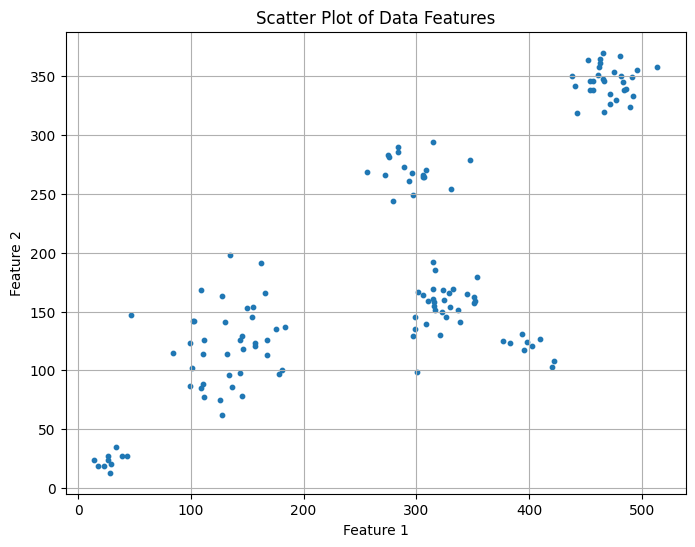

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(df['feature_1'], df['feature_2'], s=10)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter Plot of Data Features')
plt.grid(True)
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   feature_1  136 non-null    uint16
 1   feature_2  136 non-null    uint16
dtypes: uint16(2)
memory usage: 676.0 bytes


## Preprocesamiento de datos

### Subtask:
Escalar las características para que todas tengan la misma influencia en el algoritmo de clustering.


In [ ]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Display the first few rows of the scaled data
display(df_scaled[:5])

array([[ 0.4876573 , -0.28143758],
       [-0.69690215, -0.88481458],
       [ 1.40743288,  1.49949773],
       [ 0.14622546, -0.23277815],
       [ 0.98238507, -0.80695948]])

## Determinación del número óptimo de clusters (k)

### Subtask:
Utilizar métodos como el método del codo (Elbow Method) o el coeficiente de silueta (Silhouette Coefficient) para encontrar el número ideal de clusters.


In [ ]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

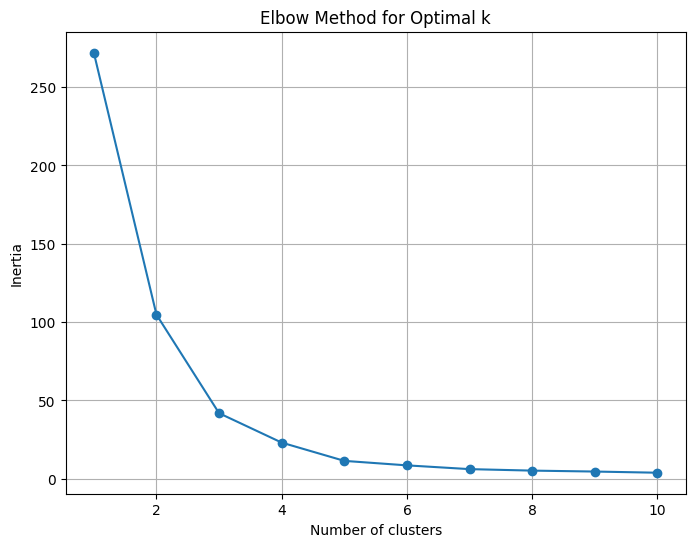

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

## Aplicación del algoritmo k-means

### Subtask:
Entrenar el modelo K-Means con el número óptimo de clusters determinado en el paso anterior.


In [ ]:
# Based on the Elbow method plot from the previous step, let's choose the optimal number of clusters.
# Looking at the plot, there seems to be an elbow around k=3. Let's choose k=3 as the optimal number of clusters.
optimal_k = 3

# Instantiate a KMeans object with the optimal number of clusters
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)

# Fit the KMeans model to the scaled data
kmeans_model.fit(df_scaled)

KMeans(n_clusters=3, n_init=10, random_state=42)

## Visualización de los clusters

### Subtask:
Visualizar los clusters encontrados para entender cómo se agrupan los datos.


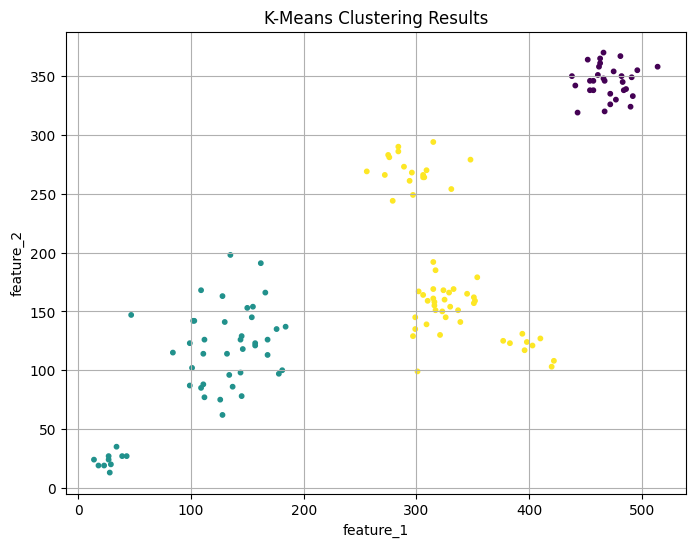

In [ ]:
# Obtain the cluster labels
cluster_labels = kmeans_model.labels_

# Add a new column named 'cluster' to the original DataFrame df
df['cluster'] = cluster_labels

# Create a scatter plot of 'feature_1' versus 'feature_2' from the df DataFrame, colored by cluster
plt.figure(figsize=(8, 6))
plt.scatter(df['feature_1'], df['feature_2'], c=df['cluster'], cmap='viridis', s=10)

# Add a title and labels
plt.title('K-Means Clustering Results')
plt.xlabel('feature_1')
plt.ylabel('feature_2')

# Display the scatter plot
plt.grid(True)
plt.show()

## Interpretación de los resultados

### Subtask:
Analizar las características de cada cluster para darles un significado y entender las diferencias entre ellos.


In [ ]:
cluster_stats = df.groupby('cluster')[['feature_1', 'feature_2']].agg(['mean', 'median', 'std', 'min', 'max'])
display(cluster_stats)

feature_1                               feature_2                    \
               mean median        std  min  max        mean median        std   
cluster                                                                         
0        470.200000  467.0  17.582123  438  514  345.500000  346.0  13.790927   
1        112.469388  128.0  50.874069   14  184  101.959184  114.0  49.284446   
2        326.333333  316.0  38.982750  256  422  186.035088  162.0  60.925295   

                   
         min  max  
cluster            
0        319  370  
1         13  198  
2         99  294

## Evaluación del modelo

### Subtask:
Evaluar la calidad del clustering utilizando métricas como el coeficiente de silueta.


In [ ]:
silhouette_avg = silhouette_score(df_scaled, kmeans_model.labels_)
print(f"The average silhouette score is: {silhouette_avg}")

The average silhouette score is: 0.6259875748455701


In [ ]:
#SOM

In [ ]:
# ---------- 1) Datos ----------
# df = pd.DataFrame(X_data, columns=['feature_1','feature_2'])
assert set(df.columns) >= {'feature_1','feature_2'}
X_raw = df[['feature_1','feature_2']].to_numpy(dtype=float)

In [ ]:
# Normalización: z-score por defecto cambiar a MinMaxScaler()
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

# --- Normalización Min-Max ---
#scaler = MinMaxScaler()
#X = scaler.fit_transform(X_raw)

N, d = X.shape
# Tamaño de rejilla ≈ 5*sqrt(N) nodos → cercano a 8x8 para N≈150
m = n = 8

In [ ]:
# ---------- 2) Entrenar SOM ----------
som = MiniSom(x=m, y=n, input_len=d, sigma=3.0, learning_rate=0.5,
              neighborhood_function='gaussian', random_seed=7)
som.random_weights_init(X)
som.train_random(X, num_iteration=3000)   # 10–20×N suele ir bien

Text(0.5, 1.0, 'Hit map sobre U-Matrix')

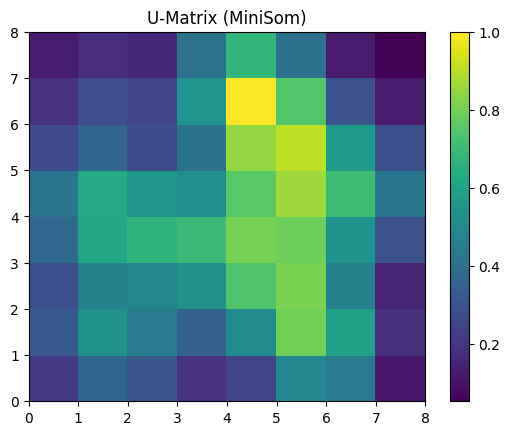

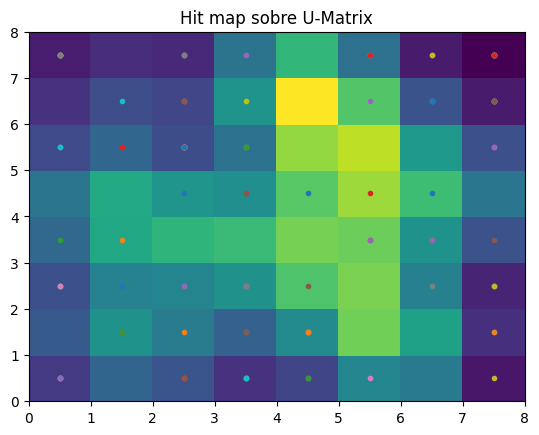

In [ ]:
# ---------- 3) U-Matrix y Hit map ----------
U = som.distance_map()           # (m,n)
hits = np.zeros((m, n), dtype=int)
for x in X:
    i, j = som.winner(x)
    hits[i, j] += 1

plt.figure(); plt.pcolor(U.T); plt.colorbar(); plt.title('U-Matrix (MiniSom)')
plt.figure(); plt.pcolor(U.T)
for x in X:
    i, j = som.winner(x); plt.plot(i+0.5, j+0.5, 'o', markersize=3)
plt.title('Hit map sobre U-Matrix')

Text(0, 0.5, 'comp2')

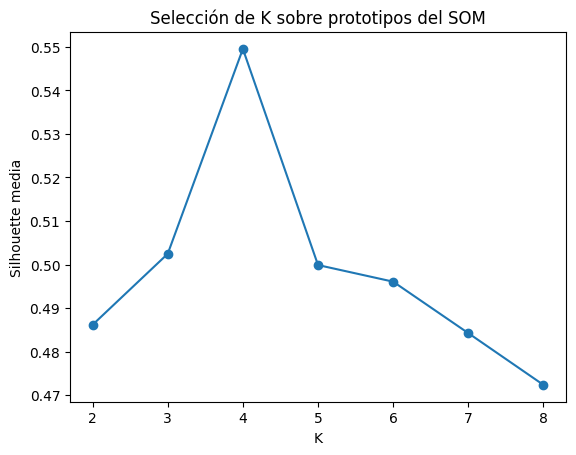

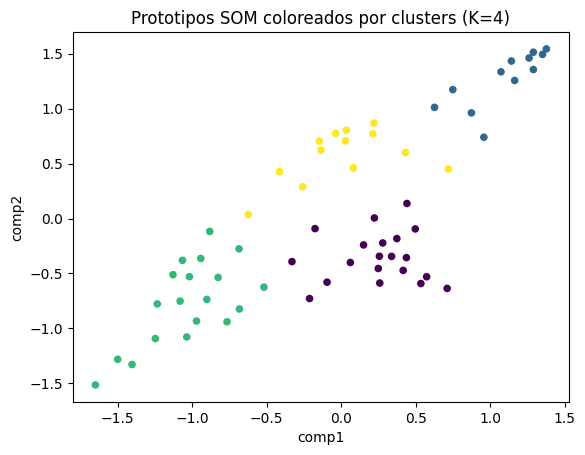

In [ ]:
# ---------- 4) Selección de K en prototipos ----------
W = som.get_weights().reshape(m*n, d)     # (64, 2)
Ks = range(2, 9)
sil, labels_by_K = [], {}
for K in Ks:
    km = KMeans(n_clusters=K, n_init=20, random_state=7)
    lab = km.fit_predict(W)
    sil.append(silhouette_score(W, lab))
    labels_by_K[K] = lab

plt.figure(); plt.plot(list(Ks), sil, marker='o')
plt.xticks(list(Ks)); plt.xlabel('K'); plt.ylabel('Silhouette media')
plt.title('Selección de K sobre prototipos del SOM')

K_star = list(Ks)[int(np.argmax(sil))]
lab_star = labels_by_K[K_star]
plt.figure()
plt.scatter(W[:,0], W[:,1], c=lab_star, s=20)
plt.title(f'Prototipos SOM coloreados por clusters (K={K_star})')
plt.xlabel('comp1'); plt.ylabel('comp2')

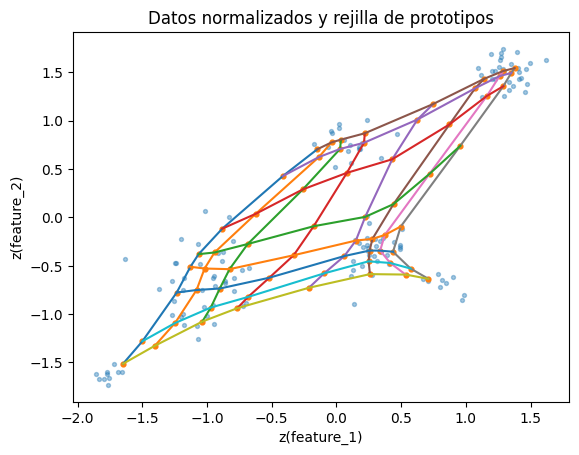

In [ ]:
# ---------- 5) Rejilla de prototipos sobre datos ----------
Wg = som.get_weights()
plt.figure()
plt.scatter(X[:,0], X[:,1], s=8, alpha=0.4)
plt.plot(Wg[:,:,0], Wg[:,:,1]); plt.plot(Wg[:,:,0].T, Wg[:,:,1].T)
plt.scatter(W[:,0], W[:,1], s=12)
plt.title('Datos normalizados y rejilla de prototipos')
plt.xlabel('z(feature_1)'); plt.ylabel('z(feature_2)')
plt.show()